# Import all necessary libraries and components

In [2]:
import argparse
import sys
import time
import os
import csv
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data
import torch.nn
import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve, accuracy_score
from PIL import Image
from tensorboardX import SummaryWriter


from networks.resnet import resnet50

from tqdm import tqdm


### Load Model for Evaluation

Select weights for desired trained model (photoshop0, photoshop0.1, photoshop0.5)

In [3]:
model = resnet50(num_classes=1)
state_dict = torch.load('checkpoints/photoshop0/model_epoch_best.pth', map_location='cpu')
model.load_state_dict(state_dict['model'])
model.eval()
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Specify Transformations

In [4]:
trans_init = []
trans = transforms.Compose(trans_init + [
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

### Test on Desired Dataset

Specify path to dataset in dir1

In [5]:
dir1 = ['./dataset/test/face',]

print('Loading [%i] datasets'%len(dir1))
data_loaders = []
for dir in dir1:
  dataset = datasets.ImageFolder(dir, transform=trans)
  data_loaders+=[torch.utils.data.DataLoader(dataset,
                                          batch_size=32,
                                          shuffle=False,
                                          num_workers=4),]

y_true, y_pred = [], []
Hs, Ws = [], []
with torch.no_grad():
  for data_loader in data_loaders:
    for data, label in tqdm(data_loader):
    # for data, label in data_loader:
      Hs.append(data.shape[2])
      Ws.append(data.shape[3])

      data = data.cuda()

      y_true.extend(label.flatten().tolist())
      y_pred.extend(model(data).sigmoid().flatten().tolist())

Hs, Ws = np.array(Hs), np.array(Ws)
y_true, y_pred = np.array(y_true), np.array(y_pred)

print('Average sizes: [{:2.2f}+/-{:2.2f}] x [{:2.2f}+/-{:2.2f}] = [{:2.2f}+/-{:2.2f} Mpix]'.format(np.mean(Hs), np.std(Hs), np.mean(Ws), np.std(Ws), np.mean(Hs*Ws)/1e6, np.std(Hs*Ws)/1e6))
print('Num reals: {}, Num fakes: {}'.format(np.sum(1-y_true), np.sum(y_true)))

r_acc = accuracy_score(y_true[y_true==0], y_pred[y_true==0] > 0.5)
f_acc = accuracy_score(y_true[y_true==1], y_pred[y_true==1] > 0.5)
acc = accuracy_score(y_true, y_pred > 0.5)
ap = average_precision_score(y_true, y_pred)

print('AP: {:2.2f}, Acc: {:2.2f}, Acc (real): {:2.2f}, Acc (fake): {:2.2f}'.format(ap*100., acc*100., r_acc*100., f_acc*100.))

Loading [1] datasets


100%|██████████| 7/7 [00:07<00:00,  1.08s/it]

Average sizes: [600.00+/-0.00] x [600.00+/-0.00] = [0.36+/-0.00 Mpix]
Num reals: 108, Num fakes: 96
AP: 88.25, Acc: 80.39, Acc (real): 87.96, Acc (fake): 71.88


### Import necessary packages and define validate and train functions

In [1]:
import os
import sys
import time
import torch
import torch.nn
import argparse
from PIL import Image
from tensorboardX import SummaryWriter

from data import create_dataloader
from earlystop import EarlyStopping
from networks.trainer import Trainer

import numpy as np
from sklearn.metrics import average_precision_score, precision_recall_curve, accuracy_score


def validate(model, classes, val_dataroot, batch_size, num_threads, mode, val_isTrain, val_no_crop, cropSize, no_flip, val_no_resize, rz_interp, loadSize, blur_prob, val_blur_sig, jpg_prob, val_jpg_method, val_jpg_qual, val_serial_batches):
    data_loader = create_dataloader(classes, val_dataroot, batch_size, num_threads, mode, val_isTrain, val_no_crop, cropSize, no_flip, val_no_resize, rz_interp, loadSize, blur_prob, val_blur_sig, jpg_prob, val_jpg_method, val_jpg_qual, val_serial_batches)

    with torch.no_grad():
        y_true, y_pred = [], []
        for img, label in data_loader:
            in_tens = img.cuda()
            y_pred.extend(model(in_tens).sigmoid().flatten().tolist())
            y_true.extend(label.flatten().tolist())

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    r_acc = accuracy_score(y_true[y_true==0], y_pred[y_true==0] > 0.5)
    f_acc = accuracy_score(y_true[y_true==1], y_pred[y_true==1] > 0.5)
    acc = accuracy_score(y_true, y_pred > 0.5)
    ap = average_precision_score(y_true, y_pred)
    return acc, ap, r_acc, f_acc, y_true, y_pred

def train(classes, niter, loss_freq, save_latest_freq, save_epoch_freq, batch_size, dataroot, mode, isTrain, no_crop, cropSize, no_flip, no_resize, rz_interp, loadSize, blur_prob, blur_sig, jpg_prob, jpg_method, jpg_qual, checkpoints_dir, name, continue_train, init_gain, optim, lr, beta1, epoch, gpu_ids, earlystop_epoch, serial_batches, num_threads):
    val_dataroot = dataroot + "/val"
    val_isTrain = False
    val_no_resize = False
    val_no_crop = False
    val_serial_batches = True
    val_jpg_method = ['pil']
    val_blur_sig = [(blur_sig[0] + blur_sig[1]) / 2]
    val_jpg_qual = [int((jpg_qual[0] + jpg_qual[-1]) / 2)]
    
    dataroot = dataroot + "/train"
    data_loader = create_dataloader(classes, dataroot, batch_size, num_threads, mode, isTrain, no_crop, cropSize, no_flip, no_resize, rz_interp, loadSize, blur_prob, blur_sig, jpg_prob, jpg_method, jpg_qual, serial_batches)
    dataset_size = len(data_loader)
    print('#training images = %d' % dataset_size)

    train_writer = SummaryWriter(os.path.join(checkpoints_dir, name, "train"))
    val_writer = SummaryWriter(os.path.join(checkpoints_dir, name, "val"))

    model = Trainer(isTrain, checkpoints_dir, name, continue_train, init_gain, optim, lr, beta1, epoch, gpu_ids)
    early_stopping = EarlyStopping(patience=earlystop_epoch, delta=-0.001, verbose=True)
    for epoch in range(niter):
        print(epoch)
        epoch_start_time = time.time()
        iter_data_time = time.time()
        epoch_iter = 0

        for i, data in enumerate(data_loader):
            model.total_steps += 1
            epoch_iter += batch_size

            model.set_input(data)
            model.optimize_parameters()

            if model.total_steps % loss_freq == 0:
                print("Train loss: {} at step: {}".format(model.loss, model.total_steps))
                train_writer.add_scalar('loss', model.loss, model.total_steps)

            if model.total_steps % save_latest_freq == 0:
                print('saving the latest model %s (epoch %d, model.total_steps %d)' %
                      (name, epoch, model.total_steps))
                model.save_networks('latest')

            # print("Iter time: %d sec" % (time.time()-iter_data_time))
            iter_data_time = time.time()

        if epoch % save_epoch_freq == 0:
            print('saving the model at the end of epoch %d, iters %d' %
                  (epoch, model.total_steps))
            model.save_networks('latest')
            model.save_networks(epoch)

        # Validation
        model.eval()
        acc, ap = validate(model.model, classes, val_dataroot, batch_size, num_threads, mode, val_isTrain, val_no_crop, cropSize, no_flip, val_no_resize, rz_interp, loadSize, blur_prob, val_blur_sig, jpg_prob, val_jpg_method, val_jpg_qual, val_serial_batches)[:2]
        val_writer.add_scalar('accuracy', acc, model.total_steps)
        val_writer.add_scalar('ap', ap, model.total_steps)
        print("(Val @ epoch {}) acc: {}; ap: {}".format(epoch, acc, ap))

        early_stopping(acc, model)
        if early_stopping.early_stop:
            cont_train = model.adjust_learning_rate()
            if cont_train:
                print("Learning rate dropped by 10, continue training...")
                early_stopping = EarlyStopping(patience=earlystop_epoch, delta=-0.002, verbose=True)
            else:
                print("Early stopping.")
                break
        model.train()

### Specify variables required to train the model

In [2]:
mode = 'binary'
arch = 'res50'
rz_interp = ['bilinear']
blur_prob = 0.5
blur_sig = 0.0, 3.0
jpg_prob = 0.5
jpg_method = ["cv2", "pil"]
jpg_quality = [30, 100]
dataroot = "./dataset"
classes = ["face"]
classes_bal = False
batch_size = 16
load_size = 600
crop_size = 556
gpu_ids = [0]
name = "photoshoped_final"
epoch = "latest"
num_threads = 0
checkpoints_dir = "./checkpoints"
serial_batches = False
resize_or_crop = "scale_and_crop"
no_flip = False
init_type = "normal"
suffix = ""
earlystop_epoch = 5
data_aug = False
optim = "adam"
new_optim = False
loss_freq = 400
save_latest_freq = 2000
save_epoch_freq = 20
continue_train = False
epoch_count = 1
last_epoch = -1
train_split = "train"
val_split = "val"
niter = 10000
beta1 = 0.9
lr = 0.0001
isTrain = True
no_crop = False
no_resize = False
init_gain = 0.02

### Train 50% Augmentation Model

In [4]:
train(classes, niter, loss_freq, save_latest_freq, save_epoch_freq, batch_size, dataroot, mode, isTrain, no_crop, crop_size, no_flip, no_resize, rz_interp, load_size, blur_prob, blur_sig, jpg_prob, jpg_method, jpg_quality, checkpoints_dir, name, continue_train, init_gain, optim, lr, beta1, epoch, gpu_ids, earlystop_epoch, serial_batches, num_threads)


face
#training images = 103
0


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


saving the model at the end of epoch 0, iters 103
face
(Val @ epoch 0) acc: 0.6519607843137255; ap: 0.6986185219283663
Validation accuracy increased (-inf --> 0.651961).  Saving model ...
1


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 1) acc: 0.6519607843137255; ap: 0.6430679585839892
EarlyStopping counter: 1 out of 5
2


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 2) acc: 0.6666666666666666; ap: 0.727660911245284
Validation accuracy increased (0.651961 --> 0.666667).  Saving model ...
3


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.6507850289344788 at step: 400
face
(Val @ epoch 3) acc: 0.6862745098039216; ap: 0.7101063617311384
Validation accuracy increased (0.666667 --> 0.686275).  Saving model ...
4


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 4) acc: 0.7009803921568627; ap: 0.7278763176708418
Validation accuracy increased (0.686275 --> 0.700980).  Saving model ...
5


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 5) acc: 0.7058823529411765; ap: 0.8052495814432942
Validation accuracy increased (0.700980 --> 0.705882).  Saving model ...
6


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 6) acc: 0.6764705882352942; ap: 0.7610306672839346
EarlyStopping counter: 1 out of 5
7


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.33413517475128174 at step: 800
face
(Val @ epoch 7) acc: 0.7401960784313726; ap: 0.7806695914548107
Validation accuracy increased (0.705882 --> 0.740196).  Saving model ...
8


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 8) acc: 0.7254901960784313; ap: 0.7748945262296982
EarlyStopping counter: 1 out of 5
9


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 9) acc: 0.7254901960784313; ap: 0.8006046619189476
EarlyStopping counter: 2 out of 5
10


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 10) acc: 0.7254901960784313; ap: 0.772900174230926
EarlyStopping counter: 3 out of 5
11


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.1981142908334732 at step: 1200
face
(Val @ epoch 11) acc: 0.7107843137254902; ap: 0.7825688667512607
EarlyStopping counter: 4 out of 5
12


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 12) acc: 0.7303921568627451; ap: 0.7777960133110752
EarlyStopping counter: 5 out of 5
Learning rate dropped by 10, continue training...
13


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 13) acc: 0.7401960784313726; ap: 0.8289423063548038
Validation accuracy increased (-inf --> 0.740196).  Saving model ...
14


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 14) acc: 0.7745098039215687; ap: 0.8523768743196927
Validation accuracy increased (0.740196 --> 0.774510).  Saving model ...
15


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.07561879605054855 at step: 1600
face
(Val @ epoch 15) acc: 0.8088235294117647; ap: 0.8443170286670294
Validation accuracy increased (0.774510 --> 0.808824).  Saving model ...
16


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 16) acc: 0.7401960784313726; ap: 0.8349414519074525
EarlyStopping counter: 1 out of 5
17


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 17) acc: 0.7598039215686274; ap: 0.8557947717692385
EarlyStopping counter: 2 out of 5
18


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 18) acc: 0.7598039215686274; ap: 0.8427436604059468
EarlyStopping counter: 3 out of 5
19


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.03682023659348488 at step: 2000
saving the latest model photoshoped_final (epoch 19, model.total_steps 2000)
face
(Val @ epoch 19) acc: 0.7696078431372549; ap: 0.838854266762574
EarlyStopping counter: 4 out of 5
20


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


saving the model at the end of epoch 20, iters 2163
face
(Val @ epoch 20) acc: 0.7549019607843137; ap: 0.8387325279411704
EarlyStopping counter: 5 out of 5
Learning rate dropped by 10, continue training...
21


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 21) acc: 0.7794117647058824; ap: 0.857375656701052
Validation accuracy increased (-inf --> 0.779412).  Saving model ...
22


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 22) acc: 0.7647058823529411; ap: 0.837281921600778
EarlyStopping counter: 1 out of 5
23


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.06324391067028046 at step: 2400
face
(Val @ epoch 23) acc: 0.75; ap: 0.8482671370947096
EarlyStopping counter: 2 out of 5
24


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 24) acc: 0.7598039215686274; ap: 0.8599462272580651
EarlyStopping counter: 3 out of 5
25


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 25) acc: 0.7598039215686274; ap: 0.856397249436612
EarlyStopping counter: 4 out of 5
26


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 26) acc: 0.7549019607843137; ap: 0.8545071937524853
EarlyStopping counter: 5 out of 5
Early stopping.


### Train 10% Augmentation Model

In [3]:
train(classes, niter, loss_freq, save_latest_freq, save_epoch_freq, batch_size, dataroot, mode, isTrain, no_crop, crop_size, no_flip, no_resize, rz_interp, load_size, .1, blur_sig, .1, jpg_method, jpg_quality, checkpoints_dir, 'photoshop0.1', continue_train, init_gain, optim, lr, beta1, epoch, gpu_ids, earlystop_epoch, serial_batches, num_threads)


face
#training images = 103
0


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


saving the model at the end of epoch 0, iters 103
face
(Val @ epoch 0) acc: 0.6862745098039216; ap: 0.6923200709515527
Validation accuracy increased (-inf --> 0.686275).  Saving model ...
1


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 1) acc: 0.6715686274509803; ap: 0.6733195419561335
EarlyStopping counter: 1 out of 5
2


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 2) acc: 0.6470588235294118; ap: 0.7211781916323452
EarlyStopping counter: 2 out of 5
3


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.20522694289684296 at step: 400
face
(Val @ epoch 3) acc: 0.6862745098039216; ap: 0.7604611167425566
EarlyStopping counter: 3 out of 5
4


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 4) acc: 0.6715686274509803; ap: 0.8167604247442086
EarlyStopping counter: 4 out of 5
5


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 5) acc: 0.696078431372549; ap: 0.7742705782848383
Validation accuracy increased (0.686275 --> 0.696078).  Saving model ...
6


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 6) acc: 0.7058823529411765; ap: 0.7970510159384473
Validation accuracy increased (0.696078 --> 0.705882).  Saving model ...
7


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.17168864607810974 at step: 800
face
(Val @ epoch 7) acc: 0.75; ap: 0.8024675379661095
Validation accuracy increased (0.705882 --> 0.750000).  Saving model ...
8


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 8) acc: 0.7352941176470589; ap: 0.803362403131143
EarlyStopping counter: 1 out of 5
9


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 9) acc: 0.7107843137254902; ap: 0.7805756453104763
EarlyStopping counter: 2 out of 5
10


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 10) acc: 0.7696078431372549; ap: 0.8418238363060431
Validation accuracy increased (0.750000 --> 0.769608).  Saving model ...
11


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.26830369234085083 at step: 1200
face
(Val @ epoch 11) acc: 0.7303921568627451; ap: 0.81567289699032
EarlyStopping counter: 1 out of 5
12


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 12) acc: 0.7303921568627451; ap: 0.8217373723037484
EarlyStopping counter: 2 out of 5
13


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 13) acc: 0.7745098039215687; ap: 0.8378028971345868
Validation accuracy increased (0.769608 --> 0.774510).  Saving model ...
14


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 14) acc: 0.7745098039215687; ap: 0.8288740309247886
EarlyStopping counter: 1 out of 5
15


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.018305039033293724 at step: 1600
face
(Val @ epoch 15) acc: 0.7254901960784313; ap: 0.8364729436869932
EarlyStopping counter: 2 out of 5
16


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 16) acc: 0.7549019607843137; ap: 0.8604904116939514
EarlyStopping counter: 3 out of 5
17


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 17) acc: 0.7352941176470589; ap: 0.817474063553522
EarlyStopping counter: 4 out of 5
18


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 18) acc: 0.7549019607843137; ap: 0.8349945014590391
EarlyStopping counter: 5 out of 5
Learning rate dropped by 10, continue training...
19


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.07859870791435242 at step: 2000
saving the latest model photoshop0.1 (epoch 19, model.total_steps 2000)
face
(Val @ epoch 19) acc: 0.7794117647058824; ap: 0.8555719338529912
Validation accuracy increased (-inf --> 0.779412).  Saving model ...
20


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


saving the model at the end of epoch 20, iters 2163
face
(Val @ epoch 20) acc: 0.803921568627451; ap: 0.8763280051062177
Validation accuracy increased (0.779412 --> 0.803922).  Saving model ...
21


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 21) acc: 0.7549019607843137; ap: 0.8476681259875395
EarlyStopping counter: 1 out of 5
22


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 22) acc: 0.7696078431372549; ap: 0.8557474294533143
EarlyStopping counter: 2 out of 5
23


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.08999665081501007 at step: 2400
face
(Val @ epoch 23) acc: 0.7892156862745098; ap: 0.8696703655678417
EarlyStopping counter: 3 out of 5
24


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 24) acc: 0.7647058823529411; ap: 0.8653308770939212
EarlyStopping counter: 4 out of 5
25


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 25) acc: 0.7892156862745098; ap: 0.865883905215973
EarlyStopping counter: 5 out of 5
Learning rate dropped by 10, continue training...
26


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 26) acc: 0.7892156862745098; ap: 0.8608317375265666
Validation accuracy increased (-inf --> 0.789216).  Saving model ...
27


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.01138664036989212 at step: 2800
face
(Val @ epoch 27) acc: 0.7647058823529411; ap: 0.8578248205332053
EarlyStopping counter: 1 out of 5
28


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 28) acc: 0.7843137254901961; ap: 0.8611986128355682
EarlyStopping counter: 2 out of 5
29


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 29) acc: 0.7843137254901961; ap: 0.8579511672154219
EarlyStopping counter: 3 out of 5
30


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 30) acc: 0.7941176470588235; ap: 0.8728179794687321
Validation accuracy increased (0.789216 --> 0.794118).  Saving model ...
31


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.0035678863059729338 at step: 3200
face
(Val @ epoch 31) acc: 0.7941176470588235; ap: 0.8683212304623875
EarlyStopping counter: 1 out of 5
32


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 32) acc: 0.7843137254901961; ap: 0.856877426907884
EarlyStopping counter: 2 out of 5
33


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 33) acc: 0.803921568627451; ap: 0.8604390995976328
Validation accuracy increased (0.794118 --> 0.803922).  Saving model ...
34


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.006679389625787735 at step: 3600
face
(Val @ epoch 34) acc: 0.7990196078431373; ap: 0.8660780740361864
EarlyStopping counter: 1 out of 5
35


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 35) acc: 0.7941176470588235; ap: 0.8644568335447106
EarlyStopping counter: 2 out of 5
36


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 36) acc: 0.7794117647058824; ap: 0.8605618435456502
EarlyStopping counter: 3 out of 5
37


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 37) acc: 0.7892156862745098; ap: 0.8696962150825552
EarlyStopping counter: 4 out of 5
38


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.00474674953147769 at step: 4000
saving the latest model photoshop0.1 (epoch 38, model.total_steps 4000)
face
(Val @ epoch 38) acc: 0.7696078431372549; ap: 0.8523812916681308
EarlyStopping counter: 5 out of 5
Early stopping.


### Train No Augmentation Model

In [3]:
train(classes, niter, loss_freq, save_latest_freq, save_epoch_freq, batch_size, dataroot, mode, isTrain, no_crop, crop_size, no_flip, no_resize, rz_interp, load_size, 0, blur_sig, 0, jpg_method, jpg_quality, checkpoints_dir, 'photoshop0', continue_train, init_gain, optim, lr, beta1, epoch, gpu_ids, earlystop_epoch, serial_batches, num_threads)

face
#training images = 103
0


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


saving the model at the end of epoch 0, iters 103
face
(Val @ epoch 0) acc: 0.5637254901960784; ap: 0.7031245098191558
Validation accuracy increased (-inf --> 0.563725).  Saving model ...
1


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 1) acc: 0.696078431372549; ap: 0.8038895337919676
Validation accuracy increased (0.563725 --> 0.696078).  Saving model ...
2


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 2) acc: 0.6862745098039216; ap: 0.7642309302882786
EarlyStopping counter: 1 out of 5
3


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.39761948585510254 at step: 400
face
(Val @ epoch 3) acc: 0.696078431372549; ap: 0.7610015608740177
EarlyStopping counter: 2 out of 5
4


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 4) acc: 0.7450980392156863; ap: 0.8766850937741038
Validation accuracy increased (0.696078 --> 0.745098).  Saving model ...
5


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 5) acc: 0.7401960784313726; ap: 0.855965486083176
EarlyStopping counter: 1 out of 5
6


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 6) acc: 0.7254901960784313; ap: 0.8060941186924837
EarlyStopping counter: 2 out of 5
7


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.09687986969947815 at step: 800
face
(Val @ epoch 7) acc: 0.7794117647058824; ap: 0.8642054383095419
Validation accuracy increased (0.745098 --> 0.779412).  Saving model ...
8


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 8) acc: 0.7843137254901961; ap: 0.8728824415928069
Validation accuracy increased (0.779412 --> 0.784314).  Saving model ...
9


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 9) acc: 0.7009803921568627; ap: 0.8008568434612677
EarlyStopping counter: 1 out of 5
10


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 10) acc: 0.7549019607843137; ap: 0.8342427518518056
EarlyStopping counter: 2 out of 5
11


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.16467685997486115 at step: 1200
face
(Val @ epoch 11) acc: 0.7254901960784313; ap: 0.810243791950986
EarlyStopping counter: 3 out of 5
12


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 12) acc: 0.7254901960784313; ap: 0.7853808860635003
EarlyStopping counter: 4 out of 5
13


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 13) acc: 0.7696078431372549; ap: 0.8567577445791412
EarlyStopping counter: 5 out of 5
Learning rate dropped by 10, continue training...
14


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 14) acc: 0.7843137254901961; ap: 0.8609410441194287
Validation accuracy increased (-inf --> 0.784314).  Saving model ...
15


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.08383216708898544 at step: 1600
face
(Val @ epoch 15) acc: 0.7892156862745098; ap: 0.8566162939196054
Validation accuracy increased (0.784314 --> 0.789216).  Saving model ...
16


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 16) acc: 0.7941176470588235; ap: 0.8646912261835646
Validation accuracy increased (0.789216 --> 0.794118).  Saving model ...
17


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 17) acc: 0.7647058823529411; ap: 0.8597700881240511
EarlyStopping counter: 1 out of 5
18


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 18) acc: 0.7696078431372549; ap: 0.8620285767767261
EarlyStopping counter: 2 out of 5
19


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.0017191139049828053 at step: 2000
saving the latest model photoshop0 (epoch 19, model.total_steps 2000)
face
(Val @ epoch 19) acc: 0.7941176470588235; ap: 0.8773901385897742
EarlyStopping counter: 3 out of 5
20


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


saving the model at the end of epoch 20, iters 2163
face
(Val @ epoch 20) acc: 0.7794117647058824; ap: 0.8726803569896946
EarlyStopping counter: 4 out of 5
21


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 21) acc: 0.8088235294117647; ap: 0.8715897376059948
Validation accuracy increased (0.794118 --> 0.808824).  Saving model ...
22


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 22) acc: 0.7990196078431373; ap: 0.8684030172607033
EarlyStopping counter: 1 out of 5
23


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.0018098518485203385 at step: 2400
face
(Val @ epoch 23) acc: 0.7892156862745098; ap: 0.8661625174736297
EarlyStopping counter: 2 out of 5
24


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 24) acc: 0.7794117647058824; ap: 0.8660799020416187
EarlyStopping counter: 3 out of 5
25


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 25) acc: 0.7794117647058824; ap: 0.863876253266664
EarlyStopping counter: 4 out of 5
26


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 26) acc: 0.7843137254901961; ap: 0.8732306802005285
EarlyStopping counter: 5 out of 5
Learning rate dropped by 10, continue training...
27


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.003312737215310335 at step: 2800
face
(Val @ epoch 27) acc: 0.7794117647058824; ap: 0.8756585273712193
Validation accuracy increased (-inf --> 0.779412).  Saving model ...
28


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 28) acc: 0.7696078431372549; ap: 0.8748891969752868
EarlyStopping counter: 1 out of 5
29


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 29) acc: 0.7941176470588235; ap: 0.8772794566123624
Validation accuracy increased (0.779412 --> 0.794118).  Saving model ...
30


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 30) acc: 0.7990196078431373; ap: 0.880434687042669
Validation accuracy increased (0.794118 --> 0.799020).  Saving model ...
31


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.016295958310365677 at step: 3200
face
(Val @ epoch 31) acc: 0.803921568627451; ap: 0.8800042642881405
Validation accuracy increased (0.799020 --> 0.803922).  Saving model ...
32


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 32) acc: 0.8186274509803921; ap: 0.882540228970273
Validation accuracy increased (0.803922 --> 0.818627).  Saving model ...
33


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 33) acc: 0.7843137254901961; ap: 0.8837114878028531
EarlyStopping counter: 1 out of 5
34


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


Train loss: 0.0013802845496684313 at step: 3600
face
(Val @ epoch 34) acc: 0.803921568627451; ap: 0.8808371223928431
EarlyStopping counter: 2 out of 5
35


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 35) acc: 0.7990196078431373; ap: 0.8862691936605378
EarlyStopping counter: 3 out of 5
36


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 36) acc: 0.7941176470588235; ap: 0.8816734637396136
EarlyStopping counter: 4 out of 5
37


C:\Users\Jakob\anaconda3\envs\DeepLearning\lib\site-packages\torchvision\transforms\functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


face
(Val @ epoch 37) acc: 0.7990196078431373; ap: 0.8816777107104382
EarlyStopping counter: 5 out of 5
Early stopping.


### Average Spectra Analysis

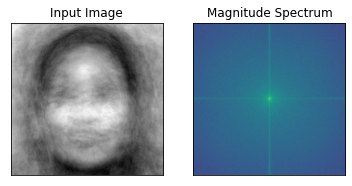

In [5]:
# https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html
# https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('./dataset/test/face/0_real/real_00907.jpg',0)
avg = img.tolist()

for i in range(867, 974):
    img = cv2.imread('./dataset/test/face/0_real/real_00{}.jpg'.format(i),0)
    for j in range(600):
        avg[j] = np.add(avg[j], img[j])

for k in range(600):
    avg[k] = avg[k] / 108

f = np.fft.fft2(avg)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(avg, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'viridis')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

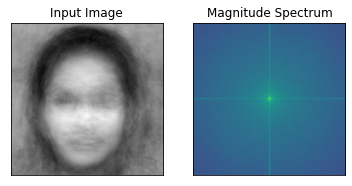

In [6]:
# https://opencv24-python-tutorials.readthedocs.io/en/stable/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html
# https://www.geeksforgeeks.org/how-to-iterate-over-files-in-directory-using-python/
import cv2
import numpy as np
from matplotlib import pyplot as plt

directory = './dataset/test/face/1_fake/'

files = []

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        files.append(f)

img = cv2.imread(files[0],0)
avg = img.tolist()

for i in range(1, len(files)):
    img = cv2.imread(files[i].format(i),0)
    for j in range(600):
        avg[j] = np.add(avg[j], img[j])

for k in range(600):
    avg[k] = avg[k] / 108

f = np.fft.fft2(avg)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(avg, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'viridis')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()